In [1]:
from sklearn.linear_model import LogisticRegression
from ipywidgets.widgets import interact
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
%matplotlib inline

# How the decision boundary affects classifier performance
In the manuscript we briefly mentioned that one constructs an ROC curve by iteratively changing the decision boundary, and recording how this affects False Positives vs. True Positives. Below we will demonstrate what this looks like in the context of a sample dataset. We'll cover the basics of classification, with an emphasis on visually displaying the more theoretical ideas discussed in the paper (e.g., the separating hyperplane).

First, we'll generate two datasets

In [2]:
# These will define the shape of the point clouds
a_slope = 2
a_offset = 3
a_noise = 4

b_slope = 6
b_offset = 0
b_noise = 2

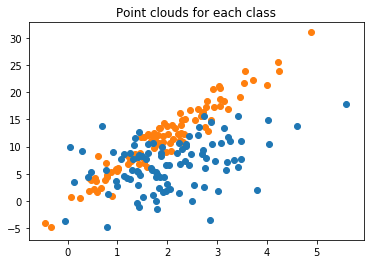

In [3]:
# Plot our datapoints
n_points = 100
a_x = np.random.randn(n_points) + 2
a_y = a_slope * a_x + a_offset + np.random.randn(n_points) * a_noise

b_x = np.random.randn(n_points) + 2
b_y = b_slope * b_x + b_offset + np.random.randn(n_points) * b_noise

fig, ax = plt.subplots()
ax.scatter(b_x, b_y, color='C1')
ax.scatter(a_x, a_y, color='C0')

ax.set_title('Point clouds for each class')

Next, we'll use `scikit-learn` to fit a Logistic Regression model. This essentially applies a non-linear function to the output of a linear model, allowing it to classify points as belonging to one of two classes.

In [4]:
# Stack these datapoints and fit a classifier on the data
X = np.hstack([[a_x, a_y], [b_x, b_y]]).T
y = np.ones(X.shape[0])
y[n_points:] = 0

model = LogisticRegression()
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now we can visualize the separating hyperplane that this model has discovered in the data.

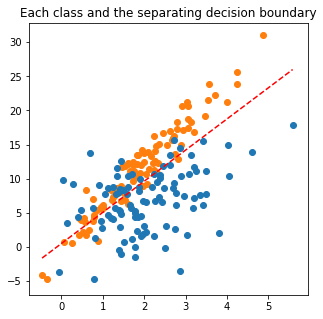

In [5]:
# Plot the line
w = model.coef_[0]
a = -w[0] / float(w[1])
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
yy_offset = model.intercept_[0] / float(w[1])
yy = a * xx - yy_offset

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(b_x, b_y, color='C1')
ax.scatter(a_x, a_y, color='C0')
ax.plot(xx, yy, 'r--')

ax.set_title('Each class and the separating decision boundary')

As we can see, the model generally splits the two groups, but there is enough noise and overlap that it's not perfect. How can we quantify this? One approach is to build an ROC curve, which we'll do belo.

Below we can perform the classification using a number of offset parameters for the decision boundary. This is similar to how ROC curves are constructed. One would compare the true-positives vs. false-positives for each position of the decision boundary, constructing the ROC curve in the process.

<function __main__.plot_distributions>

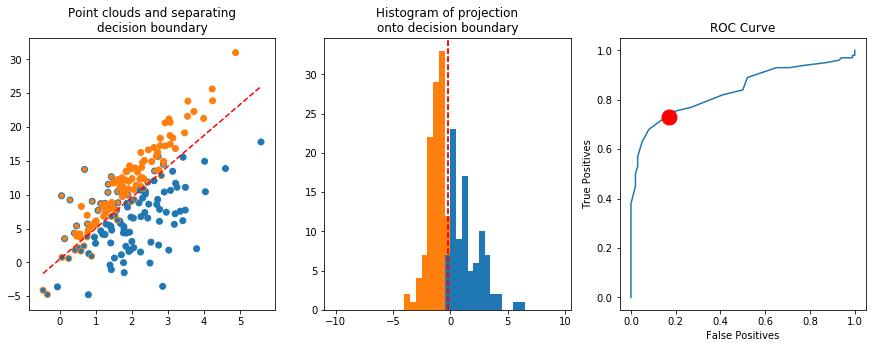

In [8]:
int_min, int_max = -10., 10.

def calculate_true_false_positives(predictions, y, positive_class=1):
    # We'll define `1` as the positive class
    positives = predictions == 1
    if sum(positives) == 0:
        true_ratio = 0
        false_ratio = 0
    else:
        # Sum the number of samples where the classifier...
        # Correctly predicted the class
        true_positives = np.sum(positives[y == 1])
        true_ratio = true_positives / sum(y == 1)

        # Incorrectly predicted the class
        false_positives = np.sum(positives[y != 1])
        false_ratio = false_positives / sum(y != 1)
    return false_ratio, true_ratio
    
def plot_distributions(intercept=model.intercept_[0]):    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot the line for this intercept
    w = model.coef_[0]
    a = -w[0] / float(w[1])
    xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    yy = a * xx - (intercept) / float(w[1])
    edgecolor = np.where(y, 'C0', 'C1')
    edgecolors = np.array([ColorConverter().to_rgb(ii) for ii in edgecolor])

    axs[0].plot(xx, yy, 'r--')
    
    # Calculate projections
    projection = np.dot(X, w)
    predictions = np.where((projection + intercept) < 0, 0, 1)

    # Plot histograms of each class
    for label in [0, 1]:
        # Select points
        positives = predictions == label
        this_proj = projection[positives]
        this_pts = X[positives]
        
        # Define colors
        markercolor = 'C1' if label == 0 else 'C0'
        markercolor = [ColorConverter().to_rgb(markercolor)] * this_pts.shape[0]
        edgecolor = edgecolors[positives]

        # Plot the point clouds and histogram
        axs[0].scatter(this_pts[:, 0], this_pts[:, 1], facecolor=markercolor,
                    edgecolor=edgecolor)
        axs[0].set(title='Point clouds and separating\ndecision boundary')
        if len(this_proj > 0):
            axs[1].hist(this_proj, bins=np.arange(-10, 10, .5), color=markercolor[0])
            axs[1].axvline(-intercept, color='r', ls='--')
        axs[1].set(title='Histogram of projection\nonto decision boundary')

        # Now highlight the ROC point
        if label == 1:
            false_ratio, true_ratio = calculate_true_false_positives(
            predictions, y)
            axs[2].plot(false_ratio, true_ratio, 'ro', ms=15, zorder=5)
            
    # Create the ROC curve itself
    roc_curve = []
    for i_intercept in np.linspace(int_min, int_max, 100):
        predictions = np.where((projection + i_intercept) < 0, 0, 1)
        
        false_ratio, true_ratio = calculate_true_false_positives(
            predictions, y)
        roc_curve.append((false_ratio, true_ratio))
    roc_curve = np.array(roc_curve).T
    
    # Now plot the ROC curve
    axs[2].plot(*roc_curve)
    axs[2].set(xlim=[-.05, 1.05], ylim=[-.05, 1.05])
    axs[2].set(ylabel='True Positives', xlabel='False Positives',
               title='ROC Curve')
interact(plot_distributions, intercept=[int_min, int_max, .1],)

**Note:** The interactivity may not work if you're using mybinder.org. In this case, cloning the repository to your computer and installing the dependencies should it working again!

Play around with the offset for the separating hyperplane above. Each point has two color components:

* The outline of the point is the *true* class for that point
* The fill of the point is the *predicted* class for that point

So if a point has a different center / outline, it means that it has been incorrectly predicted. Since in this case the blue class is the "positive" class, look at how the point on the ROC curve changes depending on how many blue points were correctly classified (true positives) vs. how many orange points were incorrectly classified as blue (false positives).